# Images Visualization

## Imports

In [1]:
import os
import random
import json

import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt

from lib.plot_utils import show_images, create_histogram
from lib.image_processing import load_numpy_data

## Config

In [2]:
# Paths to the folders with the subjects data: "posi" = COVID patients, "neg" = No COVID patients
posi_path = "../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/"
neg_path = "../../../datasets/BIMCV-COVID19-cIter_1_2-Negative/covid19_neg/"

# Paths to the TSVs with all the images file pahts by subject and session
posi_partitions_path = os.path.join(posi_path, "derivatives/partitions.tsv")
neg_partitions_path = os.path.join(neg_path, "derivatives/partitions.tsv")

## Load CSV data

In [3]:
# Load dataframe with all the images by session and subject
cols = ["subject", "session", "filepath"]  # The original columns must be fixed
posi_df = pd.read_csv(posi_partitions_path, sep="\t", header=0, names=cols)
neg_df = pd.read_csv(neg_partitions_path, sep="\t", header=0, names=cols)

print("Positive patients\n", posi_df.head())
print("\nNegative patients\n", neg_df.head())

Positive patients
       subject     session                                           filepath
0  sub-S03044  ses-E06138  ./sub-S03044/ses-E06138/mod-rx/sub-S03044_ses-...
1  sub-S03044  ses-E06790  ./sub-S03044/ses-E06790/mod-rx/sub-S03044_ses-...
2  sub-S03044  ses-E07712  ./sub-S03044/ses-E07712/mod-rx/sub-S03044_ses-...
3  sub-S03045  ses-E06139  ./sub-S03045/ses-E06139/mod-rx/sub-S03045_ses-...
4  sub-S03045  ses-E06910  ./sub-S03045/ses-E06910/mod-rx/sub-S03045_ses-...

Negative patients
       subject     session                                           filepath
0  sub-S04523  ses-E08987  ./sub-S04523/ses-E08987/sub-S04523_ses-E08987_...
1  sub-S04523  ses-E08987  ./sub-S04523/ses-E08987/sub-S04523_ses-E08987_...
2  sub-S04523  ses-E13449  ./sub-S04523/ses-E13449/sub-S04523_ses-E13449_...
3  sub-S04523  ses-E53140  ./sub-S04523/ses-E53140/sub-S04523_ses-E53140_...
4  sub-S04523  ses-E53140  ./sub-S04523/ses-E53140/sub-S04523_ses-E53140_...


## Show random images

The next cell takes N random images (with view AP or PA) and shows them in a grid.

In [4]:
N = 4  # Number of images to show
patients_type = "posi"  # From which patients to select the images: "posi" or "neg"

if patients_type == "posi":
    part_df = posi_df
    subjects_path = posi_path
else:
    part_df = neg_df
    subjects_path = neg_path
    
# Get only AP/PA images
ap_pa_paths = [path for path in part_df["filepath"] if "vp-ap" in path or "vp-pa" in path]

Images to show:
./sub-S12756/ses-E26725/mod-rx/sub-S12756_ses-E26725_run-1_bp-chest_vp-pa_cr.png
./sub-S10490/ses-E18197/mod-rx/sub-S10490_ses-E18197_run-1_bp-chest_vp-ap_dx.png
./sub-S09365/ses-E20937/mod-rx/sub-S09365_ses-E20937_run-1_bp-chest_vp-ap_dx.png
./sub-S03337/ses-E06582/mod-rx/sub-S03337_ses-E06582_acq-1_run-1_bp-chest_vp-pa_dx.png


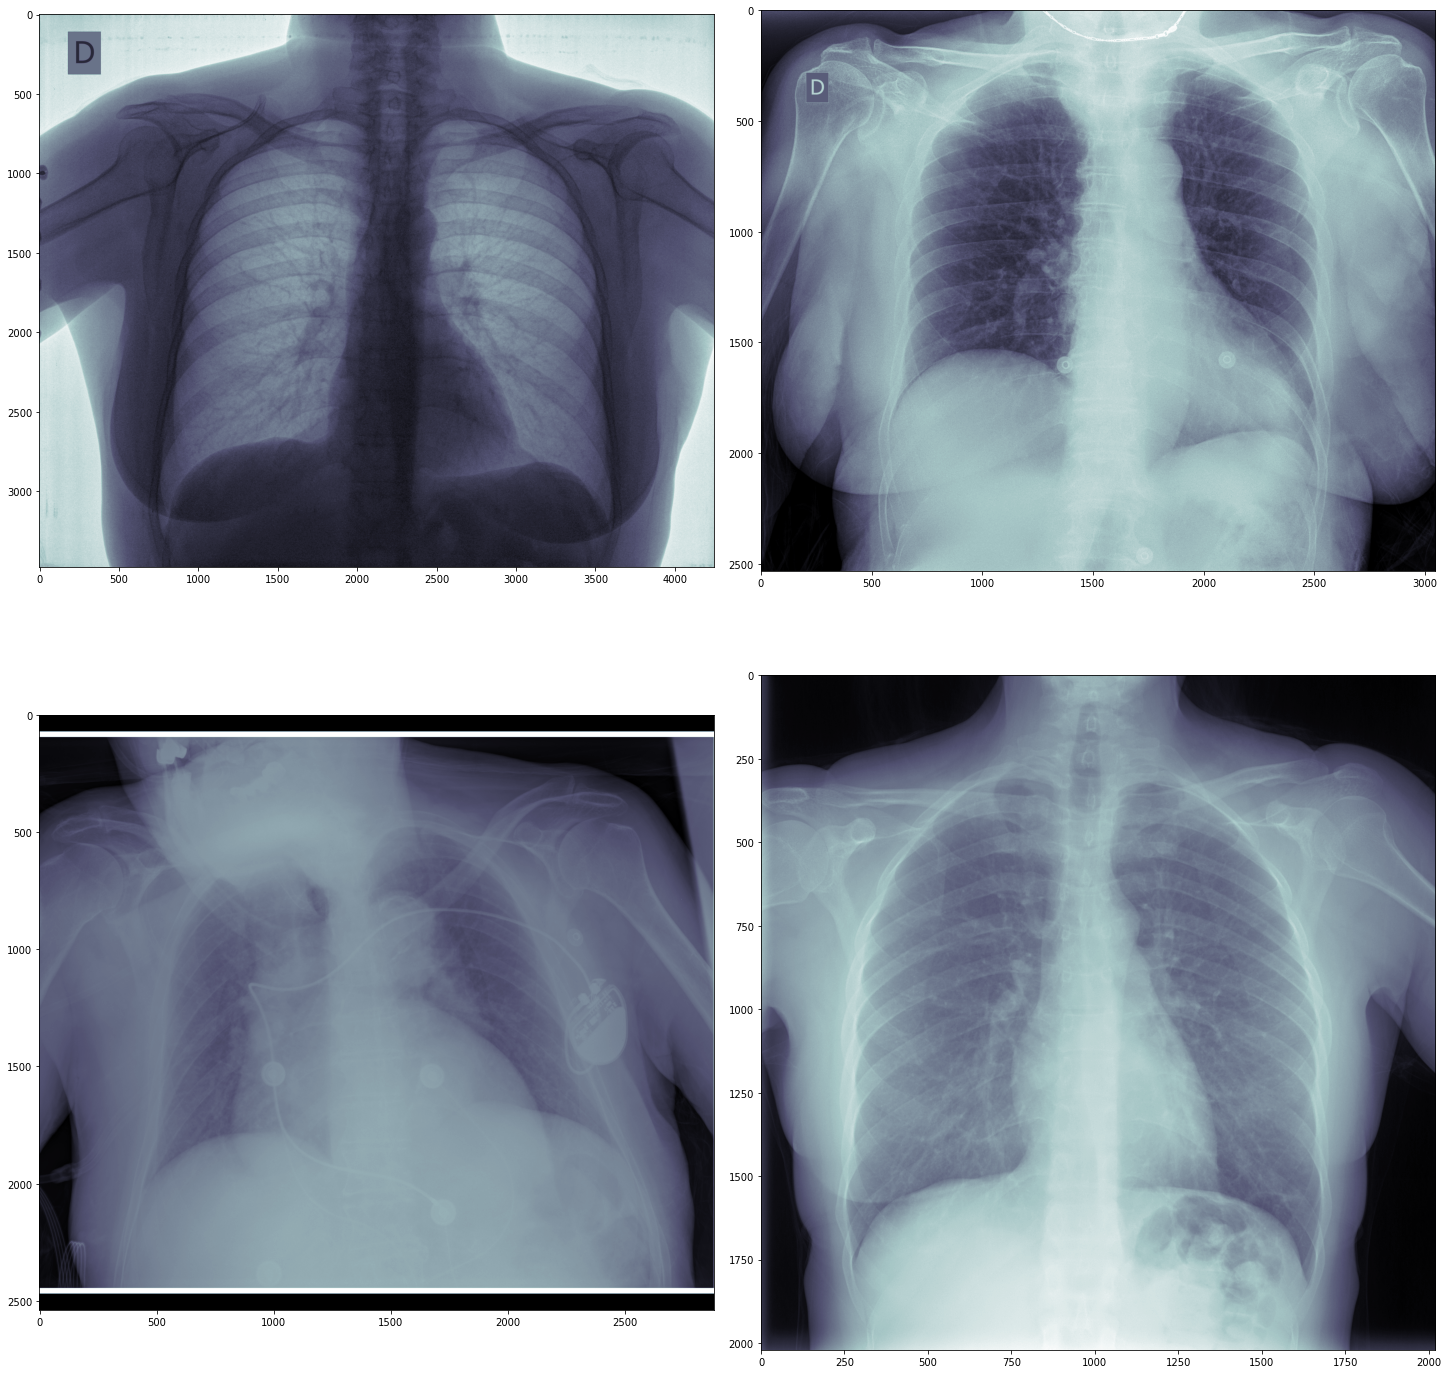

In [5]:
# Get random images
sampled_imgs = random.sample(ap_pa_paths, N)
print("Images to show:")
for img in sampled_imgs:
    print(img)

# Get the full path. "img_paths" are relative to the main data folder
img_paths = [os.path.join(subjects_path, f) for f in sampled_imgs]

if patients_type == "neg":
    # Fix paths of the "neg" set. The paths of the TSV should have a "mod-rx" folder before the file name
    # in the relative path to match the real folder structure of the given dataset
    def fix_path(path: str):
        parts = path.split('/')
        return '/'.join([*parts[:-1], "mod-rx", parts[-1]])

    img_paths = list(map(fix_path, img_paths))

# Load the images to plot
img_arrs = [load_numpy_data(f_path) for f_path in img_paths]

# Plot the images grid
show_images(img_arrs, grid_width=20, grid_height=20)

## Show images after preprocessing

Now we take the images selected in the previous cell and we apply a histogram equalization to improve the contrast and in case of activating the RGB mode, the image is colored with a colormap to get a RGB image. If the image is "monochrome 1" we invert the values of the image.


The image '../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/./sub-S12756/ses-E26725/mod-rx/sub-S12756_ses-E26725_run-1_bp-chest_vp-pa_cr.png' is 'MONOCHROME1'
 ** Going to invert image **

The image '../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/./sub-S10490/ses-E18197/mod-rx/sub-S10490_ses-E18197_run-1_bp-chest_vp-ap_dx.png' is 'MONOCHROME2'

The image '../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/./sub-S09365/ses-E20937/mod-rx/sub-S09365_ses-E20937_run-1_bp-chest_vp-ap_dx.png' is 'MONOCHROME2'
JSON with metadata not found for image '../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/./sub-S03337/ses-E06582/mod-rx/sub-S03337_ses-E06582_acq-1_run-1_bp-chest_vp-pa_dx.png'


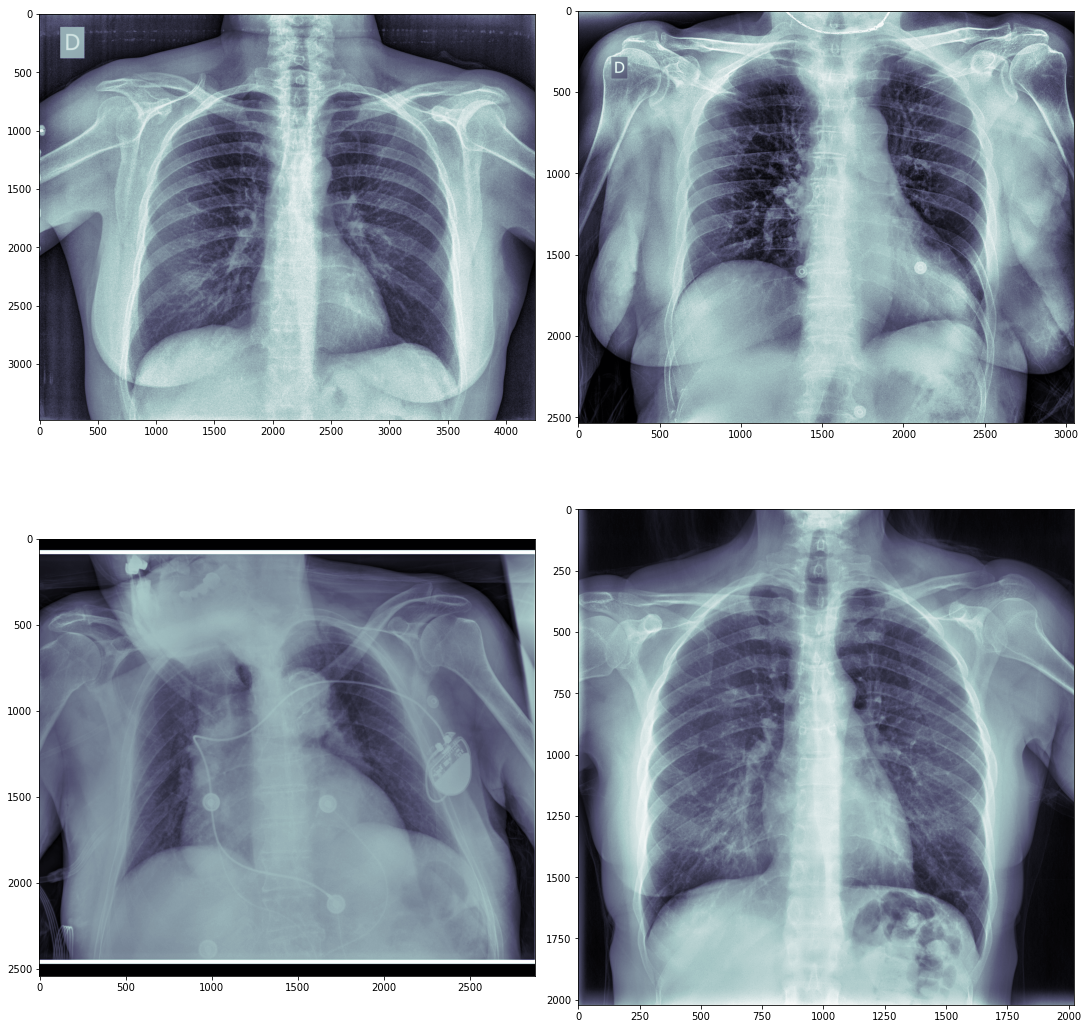

In [6]:
# Select equalization mode
#  - Note: More info in: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
#eq_func = exposure.equalize_hist  # histogram equalization
eq_func = exposure.equalize_adapthist  # Adaptive equalization

to_rgb = False  # To transform the image to RGB
colormap = "jet"  # Color map (from matplotlib) to color the image
n_colors = 100  # Number of colors tu use in the map

preproc_imgs = []  # To store the images with the preprocessing applied
for img_path in img_paths:
    img = load_numpy_data(img_path)
    
    # The images that are monochrome 1 must be inverted
    json_path = img_path[:-4] + ".json"
    if os.path.isfile(json_path):
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            img_type = data["00280004"]["Value"][0]
            print(f"\nThe image '{img_path}' is '{img_type}'")
            if img_type == "MONOCHROME1":
                print(f" ** Going to invert image **")
                img = img.max() - img  # Invert the image
    else:
        print(f"JSON with metadata not found for image '{img_path}'")
    
    img = eq_func(img)  # Apply equalization
    
    if to_rgb:
        cmap = plt.get_cmap(colormap, lut=100)
        img = cmap(img)
    
    preproc_imgs.append(img)  # Store the preprocessed image

# Plot the images grid
show_images(preproc_imgs, grid_width=15, grid_height=15)

Plot the histograms of the pixels values for each image shown

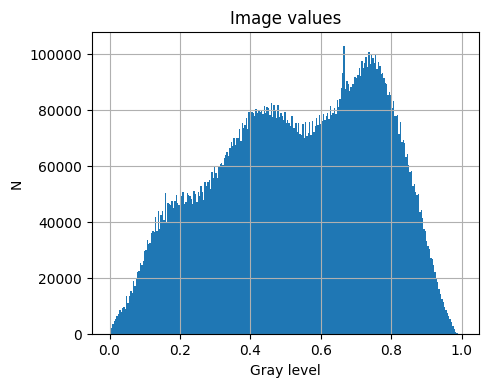

<Figure size 432x288 with 0 Axes>

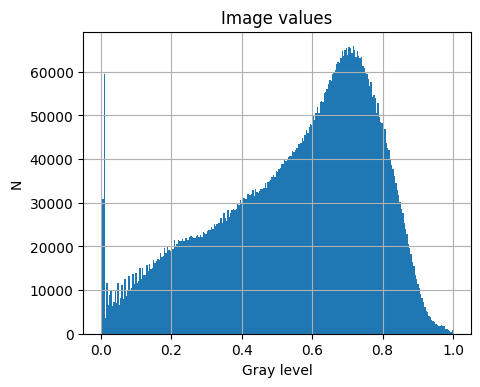

<Figure size 432x288 with 0 Axes>

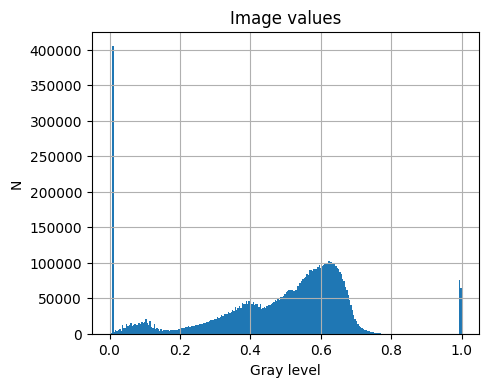

<Figure size 432x288 with 0 Axes>

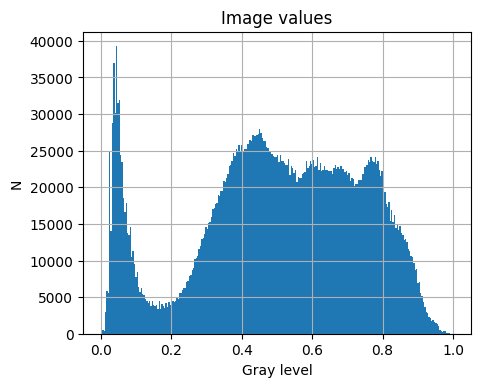

<Figure size 432x288 with 0 Axes>

In [7]:
if not to_rgb:
    for img in preproc_imgs:
        create_histogram(img.flatten(), title="Image values", ylabel="N", xlabel="Gray level", bins=256, log_yscale=False)

## Show a specific images

### Select the images to show

If you only set the "sub_id" all the images from all the session of that subject will be shown. And if you set the "sess_id" all the images from that session will be shown.

In [8]:
# Use the empty string ("") to delete a field
# Note: The session or subject ID will be searched within the selected "patients_type" selected
sub_id = ""
sess_id = "ses-E25558"

select_only_ap_pa = True  # To show only the anterior-posterior and posterior-anterior images

### Show the images selected

Images to show:
./sub-S12367/ses-E25558/mod-rx/sub-S12367_ses-E25558_run-1_bp-chest_vp-ap_dx.png


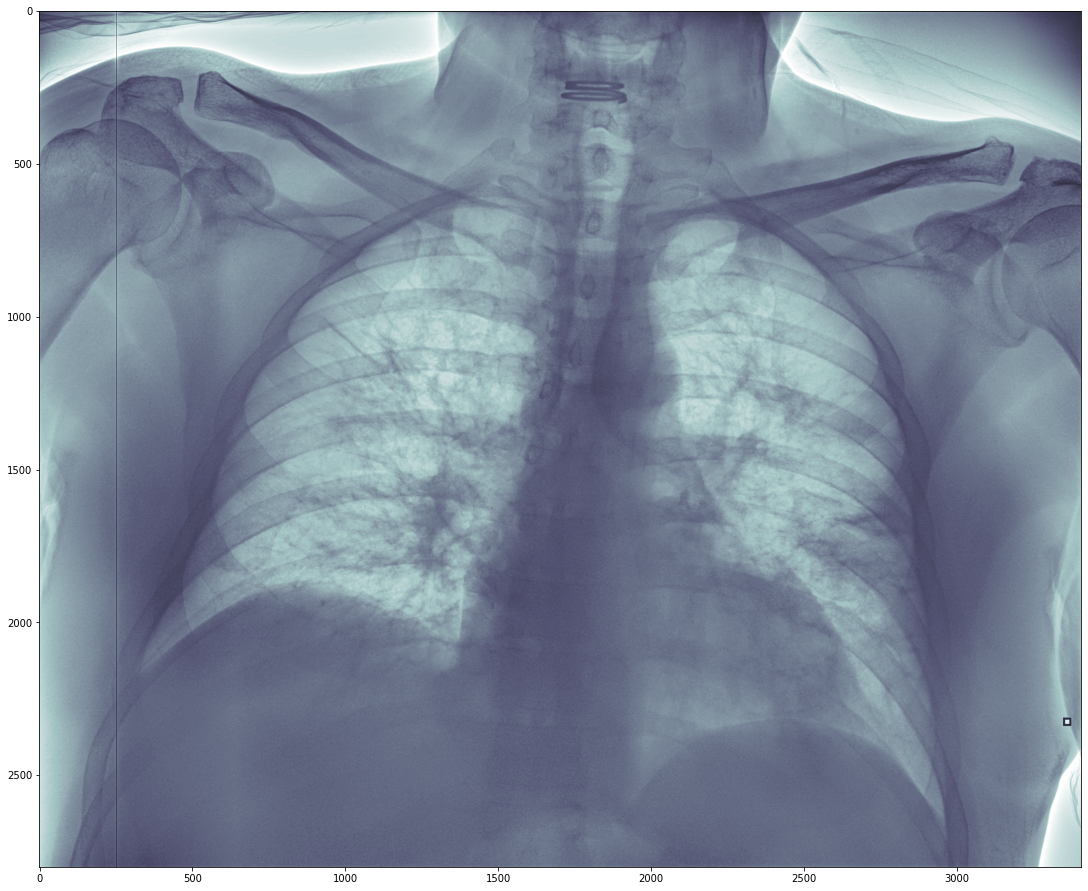

In [9]:
# Get the file paths of the images to show
selected_imgs = []
if sess_id != "":
    selected_imgs = part_df[part_df["session"] == sess_id]["filepath"].values
elif sub_id != "":
    selected_imgs = part_df[part_df["subject"] == sub_id]["filepath"].values
else:
    raise Exception("Please provide a subject ID or a session ID to find the images to show")

if len(selected_imgs) == 0:
    raise Exception(f'No images found with the provided IDs: sub_id = "{sub_id}" - sess_id = "{sess_id}"')

if select_only_ap_pa:
    # Get only AP/PA images
    selected_imgs = [img_path for img_path in selected_imgs if "vp-ap" in img_path or "vp-pa" in img_path]

# Only show the .png files. (Remove .nii.gz)
selected_imgs = [img_path for img_path in selected_imgs if img_path.endswith(".png")]

print("Images to show:")
for img in selected_imgs:
    print(img)
    
# Get the full path. "img_paths" are relative to the main data folder
img_paths = [os.path.join(subjects_path, f) for f in selected_imgs]

if patients_type == "neg":
    # Fix paths of the "neg" set. The paths of the TSV should have a "mod-rx" folder before the file name
    # in the relative path to match the real folder structure of the given dataset
    def fix_path(path: str):
        parts = path.split('/')
        return '/'.join([*parts[:-1], "mod-rx", parts[-1]])

    img_paths = list(map(fix_path, img_paths))

# Load the images to plot
img_arrs = [load_numpy_data(f_path) for f_path in img_paths]

# Equalize the loaded images
eq_imgs = [exposure.equalize_adapthist(img) for img in img_arrs]

# Plot the images grid
show_images(eq_imgs, grid_width=15, grid_height=15)